# Машинное обучение, DS-поток, осень 2024

## Задание ML.10


**Правила:**

* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания будут сдавать устный зачет.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*
* В каждой задаче не забывайте делать **пояснения и выводы**.

**Баллы за задание**  
Задача 1. &mdash; **200 баллов**  

Всего &mdash; **200 баллов**  

In [102]:
# Bot check

# HW_ID: ds_ml10
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: not final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

In [104]:
import time
import numpy as np
from collections import defaultdict

import seaborn as sns
sns.set(palette='Set2')
import matplotlib.pyplot as plt
from IPython.display import clear_output

import torch
from torch import nn
import torch.nn.functional as F
from torchinfo import summary
import torchvision
from torchvision import transforms
from captum.attr import Occlusion
from captum.attr import visualization as viz

from tqdm import tqdm
import random

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Задача 1. Исследование свойств сверток

#### 1. Данные

Обратимся к датасету CIFAR10. Скачаем тренировочную и тестовую части данных.

In [105]:
# Часть данных для обучения
train_dataset = torchvision.datasets.CIFAR10(
    root='./cifar', download=True, train=True, transform=transforms.ToTensor()
)

# Валидационная / тестовая часть данных
val_dataset = torchvision.datasets.CIFAR10(
    root='./cifar', download=True, train=False, transform=transforms.ToTensor()
)

# Классы объектов в датасете
classes = (
    'plane', 'car', 'bird', 'cat',
    'deer', 'dog', 'frog', 'horse', 'ship', 'truck'
)

Files already downloaded and verified
Files already downloaded and verified


Проверим размеры датасета.

In [106]:
len(train_dataset), len(val_dataset)

(50000, 10000)

Иллюстрируем 2 примера изображений.

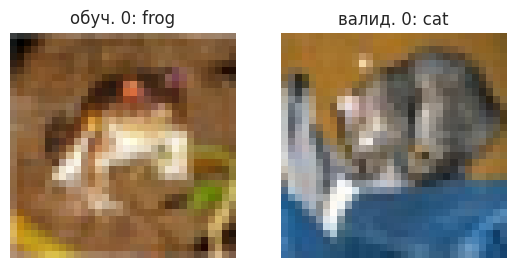

In [107]:
train_idx, val_idx = 0, 0

plt.subplot(1, 2, 1)
plt.imshow(train_dataset[train_idx][0].permute(1, 2, 0))
plt.title(f'обуч. {train_idx}: {classes[train_dataset[train_idx][1]]}')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(val_dataset[val_idx][0].permute(1, 2, 0))
plt.title(f'валид. {val_idx}: {classes[val_dataset[val_idx][1]]}')
plt.axis('off')

plt.show()

In [108]:
train_dataset[train_idx][0].shape

torch.Size([3, 32, 32])

#### 2. Различия между свертками

Постройте модель состоящую из 3 сверточных слоев с параметрами `kernel_size=3` и `stride=1` по правилу
$$INPUT \to [CONV \to RELU]^3 \to POOL \to FC \to RELU \to FC,$$

Также можно пользоваться `Dropout` и `BatchNorm`.
Пример аналогичного построения см. в семинаре.

In [109]:
class SimpleConvNet(nn.Module):
    def __init__(self):
        super(SimpleConvNet, self).__init__()

        # [CONV → RELU]
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.bn1 = nn.BatchNorm2d(32)
        self.dropout1 = nn.Dropout(0.3)
        self.relu1 = nn.ReLU()

        # [CONV → RELU]
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.bn2 = nn.BatchNorm2d(64)
        self.dropout2 = nn.Dropout(0.3)
        self.relu2 = nn.ReLU()

        # [CONV → RELU]
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.bn3 = nn.BatchNorm2d(128)
        self.dropout3 = nn.Dropout(0.3)
        self.relu3 = nn.ReLU()

        # POOL
        self.pool = nn.MaxPool2d(4)
        self.bn4 = nn.BatchNorm2d(128)
        self.dropout4 = nn.Dropout(0.3)

        # FC
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 6 * 6, 512)
        self.dropout5 = nn.Dropout(0.3)
        self.relu4 = nn.LeakyReLU()
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        # [CONV → RELU]^3
        x = self.relu1(self.dropout1(self.bn1(self.conv1(x))))
        x = self.relu2(self.dropout2(self.bn2(self.conv2(x))))
        x = self.relu3(self.dropout3(self.bn3(self.conv3(x))))

        # POOL
        x = self.pool(x)
        x = self.bn4(x)
        x = self.dropout4(x)

        # FC
        x = self.flatten(x)
        x = self.relu4(self.dropout5(self.fc1(x)))
        x = self.fc2(x)

        return x

Выполните следующие действия.
1. Посчитайте общее количество параметров сети и количество параметров в сверточных слоях.
2. Обучите ее на тренировочной части данных и сохраните веса обученной модели.
3. Посчитайте среднее время одного прямого прохода (forward pass) и среднее время обратного прохода (backward pass) по сети во время обучения.
4. Сохраните историю изменения ошибки (loss) и точности (accuracy) во время обучения.

1. Посчитаем общее количество параметров сети и количество параметров в сверточных слоях.

In [110]:
model = SimpleConvNet().to(device)

reuslts = summary(model, (1, 3, 32, 32), device="cpu")
reuslts

Layer (type:depth-idx)                   Output Shape              Param #
SimpleConvNet                            [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 30, 30]           896
├─BatchNorm2d: 1-2                       [1, 32, 30, 30]           64
├─Dropout: 1-3                           [1, 32, 30, 30]           --
├─ReLU: 1-4                              [1, 32, 30, 30]           --
├─Conv2d: 1-5                            [1, 64, 28, 28]           18,496
├─BatchNorm2d: 1-6                       [1, 64, 28, 28]           128
├─Dropout: 1-7                           [1, 64, 28, 28]           --
├─ReLU: 1-8                              [1, 64, 28, 28]           --
├─Conv2d: 1-9                            [1, 128, 26, 26]          73,856
├─BatchNorm2d: 1-10                      [1, 128, 26, 26]          256
├─Dropout: 1-11                          [1, 128, 26, 26]          --
├─ReLU: 1-12                             [1, 128, 26, 26]          --
├─Ma

In [111]:
print(f"Всего параметров сети: {reuslts.total_params}")


conv_layers = [model.conv1, model.conv2, model.conv3]
conv_params = 0
for layer in conv_layers:
    conv_params += layer.in_channels * layer.out_channels * layer.kernel_size[0] ** 2 + layer.out_channels
print(f"Всего параметров в сверточных слоях: {conv_params}")

Всего параметров сети: 2458890
Всего параметров в сверточных слоях: 93248


2. Обучим модель и сохраним веса.

In [112]:
def train(
    model,
    criterion,
    optimizer,
    train_batch_gen,
    val_batch_gen,
    num_epochs=40
):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.

    :param model: обучаемая модель
    :param criterion: функция потерь
    :param optimizer: метод оптимизации
    :param train_batch_gen: генератор батчей для обучения
    :param val_batch_gen: генератор батчей для валидации
    :param num_epochs: количество эпох

    :return: обученная модель
    :return: (dict) accuracy и loss на обучении и валидации ("история" обучения)
    '''

    history = defaultdict(lambda: defaultdict(list))

    for epoch in tqdm(range(num_epochs)):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        start_time = time.time()

        # Устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True)

        # На каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            # Обучаемся на батче (одна "итерация" обучения нейросети)
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            # Логиты на выходе модели
            logits = model(X_batch)

            # Подсчитываем лосс
            loss = criterion(logits, y_batch.long().to(device))

            # Обратный проход
            loss.backward()
            # Шаг градиента
            optimizer.step()
            # Зануляем градиенты
            optimizer.zero_grad()

            # Сохраняем лоссы и точность на трейне
            train_loss += loss.detach().cpu().numpy()
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # Подсчитываем лоссы и сохраняем в "историю"
        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen)
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)

        # Устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False)

        # Полный проход по валидации
        for X_batch, y_batch in val_batch_gen:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            # Логиты, полученные моделью
            logits = model(X_batch)

            # Лосс на валидации
            loss = criterion(logits, y_batch.long().to(device))

            # Сохраняем лоссы и точность на валидации
            val_loss += loss.detach().cpu().numpy()
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            val_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # Подсчитываем лоссы и сохраняем в "историю"
        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen)
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)

        clear_output(wait=True)

        # Печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))

    return model, history

In [113]:
batch_size = 64

train_batch_gen = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_batch_gen = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [114]:
import json
 

def load_history(filename): 
    with open(filename, "r") as f: 
        history = json.load(f) 
        return history

In [115]:
def train_model(
    model,
    saving_flag,
    use_weights_flag,
    train_flag,
    device,
    train_batch_gen,
    val_batch_gen,
    path_weights = "model_weights.pth",
    path_history = "training_history.json"
):
    model.to(device)
    history = 0

    if use_weights_flag:
        model.load_state_dict(
            torch.load(path_weights, map_location=torch.device("cpu"))
        )
        history = load_history(path_history)

        return history

    if train_flag:
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)

        trained_model, history = train(
            model, criterion, optimizer, train_batch_gen, val_batch_gen, num_epochs=40
        )

    if saving_flag:
        torch.save(model.state_dict(), path_weights)

        # Сохранение истории в файл
        with open(path_history, "w") as f:
            json.dump(history, f)

    if train_flag:
        return history


model = SimpleConvNet()
history = train_model(
    model=model,
    saving_flag=True,
    use_weights_flag=False,
    train_flag=True,
    device=device,
    train_batch_gen=train_batch_gen,
    val_batch_gen=val_batch_gen,
)

100%|██████████| 40/40 [09:07<00:00, 13.68s/it]

Epoch 40 of 40 took 13.673s
  training loss (in-iteration): 	0.167714
  validation loss (in-iteration): 	2.240177
  training accuracy: 			94.34 %
  validation accuracy: 			57.55 %


3. Посчитаем среднее время одного forward pass-a и среднее время backward pass-a.

In [116]:
def measure_time(model, dataloader, device, optimizer, criterion):
    model.to(device)
    model.eval()  
    total_forward_time = 0
    total_backward_time = 0
    num_batches = len(dataloader)

    with torch.no_grad():  
        for inputs, labels in tqdm(dataloader, desc="Прямой проход"):
            inputs, labels = inputs.to(device), labels.to(device)

            start_time = time.time()
            outputs = model(inputs)  
            forward_time = time.time() - start_time
            total_forward_time += forward_time

    model.train()  

    for inputs, labels in tqdm(dataloader, desc="Обратный проход"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  
        outputs = model(inputs)  
        loss = criterion(outputs, labels)  

        start_time = time.time()
        loss.backward()  
        backward_time = time.time() - start_time
        total_backward_time += backward_time

    avg_forward_time = total_forward_time / num_batches
    avg_backward_time = total_backward_time / num_batches

    model.eval()

    return avg_forward_time, avg_backward_time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleConvNet().to(device)  
dataloader = val_batch_gen  
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

avg_forward_time, avg_backward_time = measure_time(model, dataloader, device, optimizer, criterion)
print(f"Среднее время forward pass: {avg_forward_time:.6f} секунд")
print(f"Среднее время backward pass: {avg_backward_time:.6f} секунд")

Обратный проход: 100%|██████████| 157/157 [00:01<00:00, 92.78it/s]

Среднее время forward pass: 0.000793 секунд
Среднее время backward pass: 0.001150 секунд


4. Сохраним историю обучения, и выведем ее в виде графика.

In [117]:
def plot_histories(histories, names):
    '''
    Функция для вывода лосса и метрики во время обучения.
    :param history: (dict) accuracy и loss на обучении и валидации
    :param names: (dict) название модели
    '''
    sns.set_style('darkgrid')
    colors = ['darkblue', 'lightcoral', 'limegreen', 'sandybrown']
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    epochs = np.min([len(h['loss']['train']) for h in histories])
    for i, (history, name) in enumerate(zip(histories, names)):
        axs[0].set_title('Лосс')
        axs[0].plot(history['loss']['train'][:epochs], label=f'{name}', lw=2, c=colors[i])
        axs[0].plot(history['loss']['val'][:epochs], lw=1.5, c=colors[i], ls='--')
        axs[0].set_xlabel('Эпохи')

        axs[1].set_title('Точность')
        axs[1].plot(history['acc']['train'][:epochs], label=f'{name}', lw=2, c=colors[i])
        axs[1].plot(history['acc']['val'][:epochs], lw=1.5, c=colors[i], ls='--')
        axs[1].set_xlabel('Эпохи')
        axs[1].legend()

    dummy_lines = [axs[0].plot([], [], c='black', lw=2)[0],
                   axs[0].plot([], [], c='black', lw=1.5, ls='--')[0]]
    for i in range(2):
        legend = axs[i].legend(loc=3-i)
        axs[i].legend(dummy_lines, ["train", "val"], loc=4)
        axs[i].add_artist(legend)
    plt.show()

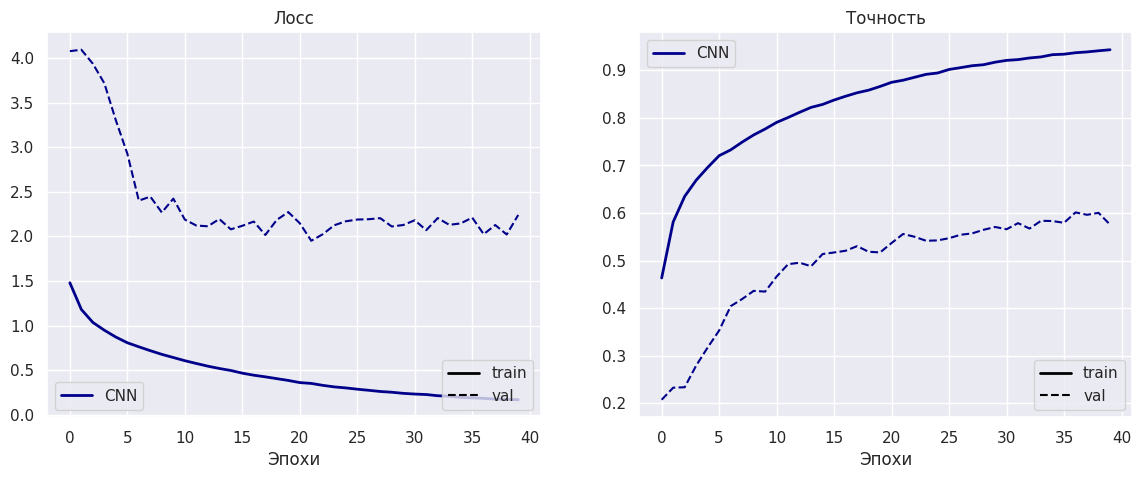

In [118]:
plot_histories([history], ["CNN"])

Посчитайте область видимости (receptive filed) нейронов последней свертки. Какую область картинки видит нейрон последнего слоя свертки?

Мы используем три свертки с размером ядра равным 3, stride = 1, padding = 0. Тогда область видимости можно вычислить по следующей реккурсивной формуле
$$
r_{l-1} = s_l \cdot r_{l} +  (k_l - s_l)
$$
где $r_3 = 3$, $r_l$ -- ширина области видимости $l$-й свертки, $k_l$ -- размер ядра

Тогда:
$$
r_2 = s_3 \cdot r_3 + (k_3 - s_3) = 1 \cdot 3 + 3 - 1 = 5
$$
$$
r_1 =  s_2 \cdot r_2 + (k_2 - s_2) = 1 \cdot 5 + 3 - 1 = 7
$$

Теперь учтем, что мы применяем pooling с размером ядра равным $k_p = 4$:
$$
rf = r_1 + (k_p - 1) = 7 + 4 - 1 = 10
$$

Таким образом область видимости последнего нейрона будет равна $r_1^2 = 100$.

**Ответ:** 100

Проведем эксперимент для сравнения работы различных сверток. Для этого постройте еще три модели, которые должны следовать перечисленным ниже требованиям.

Во-первых, необходимо сделать такие модели, у которых область видимости (receptive field) последнего сверточного слоя такая же как у модели построенной ранее. Тогда мы будем ожидать у моделей схожую обобщающую способность.

Во-вторых, установим ограничение на количество каналов в свертках. Оно нужно для корректной оценки параметров и скорости работы сети. Пусть $с_{k,in}$ и $c_{k, out}$ &mdash; количество каналов на входе и на выходе свертки на слое $k$ модели. Тогда сумма $\sum_{k} с_{k,in} c_{k, out}$ должна быть одинаковой для всех моделей, т.е. для исходной и трех новых моделей. Для того, чтобы добиться такого результата, можно дополнительно использовать свертки с `kernel_size=1`. При сравнении моделей в выводе поясните необходимость данного требования.

Наконец, т.к. мы хотим рассмотреть работу различных сверток, то перечислим особенности каждой модели по порядку.

1. Включает в себя свертку c `kernel_size=7, stride=1`.
2. Включает в себя свертку c `kernel_size=5, stride=1`.
3. Включает себя свертки c `kernel_size=3, stride=2`.

In [119]:
class FirstModel(nn.Module):
    def __init__(self):
        super(FirstModel, self).__init__()

        # [CONV → RELU]
        self.conv1 = nn.Conv2d(3, 32, 7)  # 7
        self.bn1 = nn.BatchNorm2d(32)
        self.dropout1 = nn.Dropout(0.3)
        self.relu1 = nn.ReLU()

        # [CONV → RELU]
        self.conv2 = nn.Conv2d(32, 64,1) # 7 + 1 - 1 = 7
        self.bn2 = nn.BatchNorm2d(64)
        self.dropout2 = nn.Dropout(0.3)
        self.relu2 = nn.ReLU()

        # [CONV → RELU]
        self.conv3 = nn.Conv2d(64, 128, 1) # 7 + 1 - 1 = 7
        self.bn3 = nn.BatchNorm2d(128)
        self.dropout3 = nn.Dropout(0.3)
        self.relu3 = nn.ReLU()

        # POOL
        self.pool = nn.MaxPool2d(3)  # 7 + 3 - 1 = 9
        self.bn4 = nn.BatchNorm2d(128)
        self.dropout4 = nn.Dropout(0.3)

        # FC
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 8 * 8, 512)
        self.dropout5 = nn.Dropout(0.3)
        self.relu4 = nn.LeakyReLU()
        self.fc2 = nn.Linear(512, 10)
    
    def forward(self, x):
        # [CONV → RELU]^3
        x = self.relu1(self.dropout1(self.bn1(self.conv1(x))))
        x = self.relu2(self.dropout2(self.bn2(self.conv2(x))))
        x = self.relu3(self.dropout3(self.bn3(self.conv3(x))))

        # POOL
        x = self.pool(x)
        x = self.bn4(x)
        x = self.dropout4(x)

        # FC
        x = self.flatten(x)
        x = self.relu4(self.dropout5(self.fc1(x)))
        x = self.fc2(x)

        return x
    

first_model = FirstModel().to(device)

reuslts = summary(first_model, (1, 3, 32, 32), device="cpu")
reuslts

Layer (type:depth-idx)                   Output Shape              Param #
FirstModel                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 26, 26]           4,736
├─BatchNorm2d: 1-2                       [1, 32, 26, 26]           64
├─Dropout: 1-3                           [1, 32, 26, 26]           --
├─ReLU: 1-4                              [1, 32, 26, 26]           --
├─Conv2d: 1-5                            [1, 64, 26, 26]           2,112
├─BatchNorm2d: 1-6                       [1, 64, 26, 26]           128
├─Dropout: 1-7                           [1, 64, 26, 26]           --
├─ReLU: 1-8                              [1, 64, 26, 26]           --
├─Conv2d: 1-9                            [1, 128, 26, 26]          8,320
├─BatchNorm2d: 1-10                      [1, 128, 26, 26]          256
├─Dropout: 1-11                          [1, 128, 26, 26]          --
├─ReLU: 1-12                             [1, 128, 26, 26]          --
├─Ma

In [120]:
class SecondModel(nn.Module):
    def __init__(self):
        super(SecondModel, self).__init__()

        # [CONV → RELU]
        self.conv1 = nn.Conv2d(3, 32, 5)  # 5
        self.bn1 = nn.BatchNorm2d(32)
        self.dropout1 = nn.Dropout(0.3)
        self.relu1 = nn.ReLU()

        # [CONV → RELU]
        self.conv2 = nn.Conv2d(32, 64,2) # 5 + 2 - 1 = 6
        self.bn2 = nn.BatchNorm2d(64)
        self.dropout2 = nn.Dropout(0.3)
        self.relu2 = nn.ReLU()

        # [CONV → RELU]
        self.conv3 = nn.Conv2d(64, 128, 2) # 6 + 2 - 1 = 7
        self.bn3 = nn.BatchNorm2d(128)
        self.dropout3 = nn.Dropout(0.3)
        self.relu3 = nn.ReLU()

        # POOL
        self.pool = nn.MaxPool2d(3)  # 7 + 3 - 1 = 9
        self.bn4 = nn.BatchNorm2d(128)
        self.dropout4 = nn.Dropout(0.3)

        # FC
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 8 * 8, 512)
        self.dropout5 = nn.Dropout(0.3)
        self.relu4 = nn.LeakyReLU()
        self.fc2 = nn.Linear(512, 10)
    
    def forward(self, x):
        # [CONV → RELU]^3
        x = self.relu1(self.dropout1(self.bn1(self.conv1(x))))
        x = self.relu2(self.dropout2(self.bn2(self.conv2(x))))
        x = self.relu3(self.dropout3(self.bn3(self.conv3(x))))

        # POOL
        x = self.pool(x)
        x = self.bn4(x)
        x = self.dropout4(x)

        # FC
        x = self.flatten(x)
        x = self.relu4(self.dropout5(self.fc1(x)))
        x = self.fc2(x)

        return x
    

second_model = SecondModel().to(device)

reuslts = summary(second_model, (1, 3, 32, 32), device="cpu")
reuslts

Layer (type:depth-idx)                   Output Shape              Param #
SecondModel                              [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 28, 28]           2,432
├─BatchNorm2d: 1-2                       [1, 32, 28, 28]           64
├─Dropout: 1-3                           [1, 32, 28, 28]           --
├─ReLU: 1-4                              [1, 32, 28, 28]           --
├─Conv2d: 1-5                            [1, 64, 27, 27]           8,256
├─BatchNorm2d: 1-6                       [1, 64, 27, 27]           128
├─Dropout: 1-7                           [1, 64, 27, 27]           --
├─ReLU: 1-8                              [1, 64, 27, 27]           --
├─Conv2d: 1-9                            [1, 128, 26, 26]          32,896
├─BatchNorm2d: 1-10                      [1, 128, 26, 26]          256
├─Dropout: 1-11                          [1, 128, 26, 26]          --
├─ReLU: 1-12                             [1, 128, 26, 26]          --
├─M

In [121]:
class ThirdModel(nn.Module):
    def __init__(self):
        super(ThirdModel, self).__init__()

        # [CONV → RELU]
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3)  # 3
        self.bn1 = nn.BatchNorm2d(32)
        self.dropout1 = nn.Dropout(0.3)
        self.relu1 = nn.ReLU()

        # [CONV → RELU]
        self.conv2 = nn.Conv2d(32, 64,kernel_size=3, stride=2) # 6 + 3 - 2 = 7
        self.bn2 = nn.BatchNorm2d(64)
        self.dropout2 = nn.Dropout(0.3)
        self.relu2 = nn.ReLU()

        # [CONV → RELU]
        self.conv3 = nn.Conv2d(64, 128, 1) # 7 + 1 - 1 = 7
        self.bn3 = nn.BatchNorm2d(128)
        self.dropout3 = nn.Dropout(0.3)
        self.relu3 = nn.ReLU()

        # POOL
        self.pool = nn.MaxPool2d(3)  # 7 + 3 - 1 = 9
        self.bn4 = nn.BatchNorm2d(128)
        self.dropout4 = nn.Dropout(0.3)

        # FC
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.dropout5 = nn.Dropout(0.3)
        self.relu4 = nn.LeakyReLU()
        self.fc2 = nn.Linear(512, 10)
    
    def forward(self, x):
        # [CONV → RELU]^3
        x = self.relu1(self.dropout1(self.bn1(self.conv1(x))))
        x = self.relu2(self.dropout2(self.bn2(self.conv2(x))))
        x = self.relu3(self.dropout3(self.bn3(self.conv3(x))))

        # POOL
        x = self.pool(x)
        x = self.bn4(x)
        x = self.dropout4(x)

        # FC
        x = self.flatten(x)
        x = self.relu4(self.dropout5(self.fc1(x)))
        x = self.fc2(x)

        return x
    

third_model = ThirdModel().to(device)

reuslts = summary(third_model, (1, 3, 32, 32), device="cpu")
reuslts

Layer (type:depth-idx)                   Output Shape              Param #
ThirdModel                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 30, 30]           896
├─BatchNorm2d: 1-2                       [1, 32, 30, 30]           64
├─Dropout: 1-3                           [1, 32, 30, 30]           --
├─ReLU: 1-4                              [1, 32, 30, 30]           --
├─Conv2d: 1-5                            [1, 64, 14, 14]           18,496
├─BatchNorm2d: 1-6                       [1, 64, 14, 14]           128
├─Dropout: 1-7                           [1, 64, 14, 14]           --
├─ReLU: 1-8                              [1, 64, 14, 14]           --
├─Conv2d: 1-9                            [1, 128, 14, 14]          8,320
├─BatchNorm2d: 1-10                      [1, 128, 14, 14]          256
├─Dropout: 1-11                          [1, 128, 14, 14]          --
├─ReLU: 1-12                             [1, 128, 14, 14]          --
├─Max

Обучите новые модели с теми же параметрами обучения, что и раньше. Для каждой из них посчитайте все характеристики, которые были посчитаны для исходной модели. Сравните результаты и сделайте выводы.

In [122]:
first_model = FirstModel()
second_model = SecondModel()
third_model = ThirdModel()

first_model_history = train_model(
    model=first_model,
    saving_flag=True,
    use_weights_flag=False,
    train_flag=True,
    device=device,
    train_batch_gen=train_batch_gen,
    val_batch_gen=val_batch_gen,
    path_weights="first_model_wieght.pth",
    path_history="fisrt_model_history.json"
)

second_model_history = train_model(
    model=second_model,
    saving_flag=True,
    use_weights_flag=False,
    train_flag=True,
    device=device,
    train_batch_gen=train_batch_gen,
    val_batch_gen=val_batch_gen,
    path_weights="second_model_wieght.pth",
    path_history="second_model_history.json"
)

third_model_history = train_model(
    model=third_model,
    saving_flag=True,
    use_weights_flag=False,
    train_flag=True,
    device=device,
    train_batch_gen=train_batch_gen,
    val_batch_gen=val_batch_gen,
    path_weights="third_model_wieght.pth",
    path_history="third_model_history.json"
)

100%|██████████| 40/40 [07:18<00:00, 10.97s/it]

Epoch 40 of 40 took 10.959s
  training loss (in-iteration): 	0.585392
  validation loss (in-iteration): 	3.995501
  training accuracy: 			79.46 %
  validation accuracy: 			29.80 %


In [123]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

first_model_avg_forward_time, fisrt_model_avg_backward_time = measure_time(
    first_model, val_batch_gen, device, optimizer, criterion
)

second_model_avg_forward_time, second_model_avg_backward_time = measure_time(
    second_model, val_batch_gen, device, optimizer, criterion
)

third_model_avg_forward_time, third_model_avg_backward_time = measure_time(
    third_model, val_batch_gen, device, optimizer, criterion
)

print(f"Среднее время forward pass для первой модели: {avg_forward_time:.6f} секунд")
print(f"Среднее время backward pass для для первой модели: {avg_backward_time:.6f} секунд")

print(f"Среднее время forward pass для второй модели: {second_model_avg_forward_time:.6f} секунд")
print(f"Среднее время backward pass для второй модели: {second_model_avg_backward_time:.6f} секунд")

print(f"Среднее время forward pass для третьей модели: {third_model_avg_forward_time:.6f} секунд")
print(f"Среднее время backward pass для третьей модели: {third_model_avg_backward_time:.6f} секунд")

Обратный проход: 100%|██████████| 157/157 [00:01<00:00, 90.76it/s]

Среднее время forward pass для первой модели: 0.000793 секунд
Среднее время backward pass для для первой модели: 0.001150 секунд
Среднее время forward pass для второй модели: 0.000781 секунд
Среднее время backward pass для второй модели: 0.001316 секунд
Среднее время forward pass для третьей модели: 0.000775 секунд
Среднее время backward pass для третьей модели: 0.001290 секунд


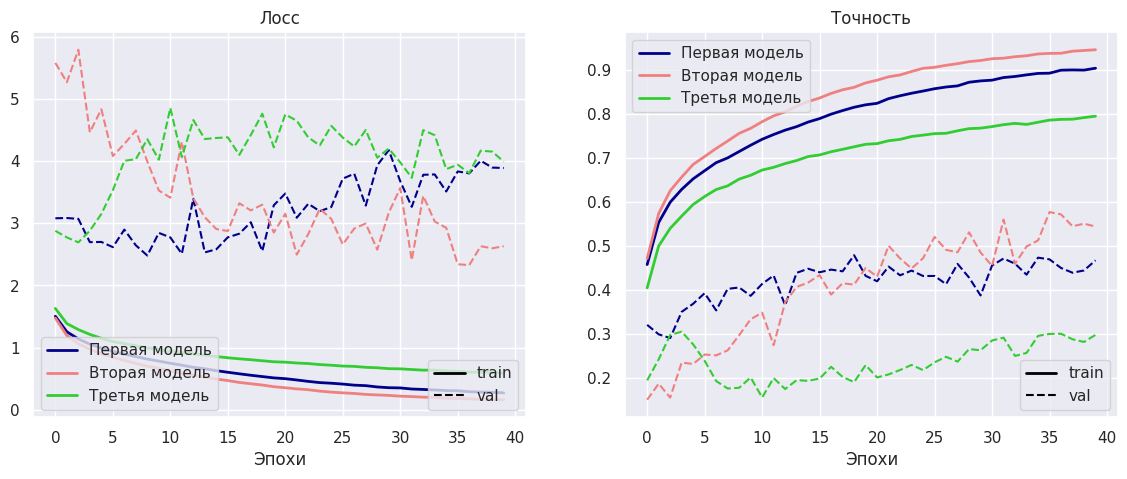

In [124]:
plot_histories(
    [first_model_history, second_model_history, third_model_history],
    ["Первая модель", "Вторая модель", "Третья модель"],
)

    Свертки с ядром размером 1 (kernel_size=1) могут использоваться для регулировки числа каналов без изменения пространственной размерности данных. Это помогает сохранить общую вычислительную нагрузку на модель, поскольку такие свертки позволяют адаптировать количество каналов, не меняя сильно размеров выходных данных.

**Выводы:** 
Как видим прямой и обратный проходы для всех трех моделей отличаются максимум на ~10%. Что говорит о том, что изменение видов сверток не повлияло на время работы

Заметим, что модель с размером ядра 7 оказалась чуть хуже модели с размером ядра 5, но зато обучилась достаточно быстро.

Заметим, что добавление stride (а значит и увеличение receptive field) сделало модель самой точной  и стабильной.

#### 3. Интерпретируемость
В этой части задания вы попробуете еще один способ интерпретации работы сверточных слоев. На лекции и семинаре для того, чтобы показать что нейроны реагируют на отдельные части изображения, использовались выходы сети целиком. Сейчас же вы сможете проверить, есть ли интерпретируемость на уровне сверточных слоев.

1. Выделите 5 изображений лягушек и 5 изображений самолетов из датасета.
2. Выберете одну из четырех обученных моделей.
3. Для каждого изображения посчитайте выходы последнего сверточного слоя модели и найдите максимумы по каналам. Должен получиться квадратный двумерный тензор для каждого изображения. Он показывает на какие области больше всего реагирует сеть для предсказания соотвествующего класса.  
4. Отобразите результат для каждого изображения.
5. Сравните активации для изображений одного класса и различных классов. Сделайте выводы.

2. В качестве модели возьмем вторую

In [125]:
best_model = second_model

1. Выделим самые вероятные уверенные ответы модели

In [126]:
plane_probs = []
frog_probs = []

# Прогоняем данные через модель и вычисляем вероятности для каждого изображения
with torch.no_grad():
    for i, (img, label) in tqdm(enumerate(val_dataset)):
        img = img.to(device)
        output = best_model(img.unsqueeze(0))  
        probs = torch.softmax(output, dim=1)   
        
        if label == classes.index('plane'):
            plane_probs.append((probs[0, classes.index('plane')].item(), i))
        elif label == classes.index('frog'):
            frog_probs.append((probs[0, classes.index('frog')].item(), i))

# Сортируем по вероятности и выбираем топ-5 изображений
plane_samples = [idx for _, idx in sorted(plane_probs, reverse=True)[:5]]
frog_samples = [idx for _, idx in sorted(frog_probs, reverse=True)[:5]]

# Извлекаем соответствующие изображения из датасета
plane_images = [val_dataset[i][0] for i in plane_samples]
frog_images = [val_dataset[i][0] for i in frog_samples]

10000it [00:09, 1027.21it/s]


3. Для каждого изображения посчитаем выходы последнего слоя и найдем максимумы по каналам.

In [127]:
def show_occlusion(img, model, class_key, classes):
    size = 9  # размер закрашенного квадрата
    stride = size // 4  # шаг между закрашенными квадратами

    img = img.to(next(model.parameters()).device)
    
    # Heatmap вероятностей классов
    heatmap = torch.zeros((img.shape[1], img.shape[2])).float()
    # Нормализующая матрица
    norm = torch.zeros((img.shape[1], img.shape[2]))

    for i in range(0, img.shape[1] - size, stride):
        for j in range(0, img.shape[2] - size, stride):
            # Закрашиваем квадрат
            img_new = img.clone()
            img_new[:, i: i + size, j:j + size] = 0.5

            # Получаем вероятность того, что картинка принадлежит заданному классу
            with torch.no_grad():
                prob = model(img_new.unsqueeze(0))[0, class_key]

            # Заполняем heatmap и норм. матрицу
            heatmap[i: i + size, j: j + size] += prob.detach().cpu()
            norm[i: i + size, j: j + size] += 1

    # Нормализуем heatmap
    heatmap = heatmap / norm

    # Визуализируем результат
    plt.figure(figsize=(8, 3))
    # Исходная картинка
    plt.subplot(1, 2, 1)
    plt.imshow(img.cpu().permute(1, 2, 0))
    plt.title(f"Метка: {classes[class_key]}")
    plt.axis('off')
    
    # Heatmap
    plt.subplot(1, 2, 2)
    plt.imshow(heatmap)
    # plt.title(f"Occlusion Heatmap for {classes[class_key]}")
    plt.colorbar()
    plt.axis('off')
    plt.tight_layout()
    plt.show()

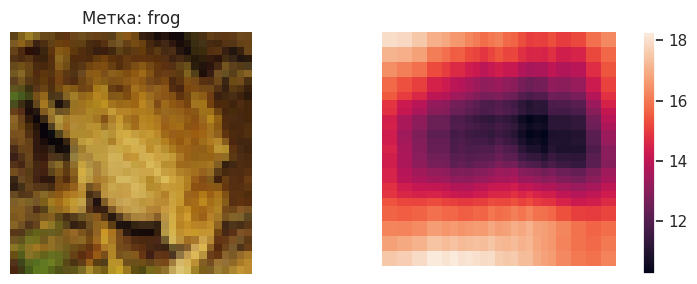

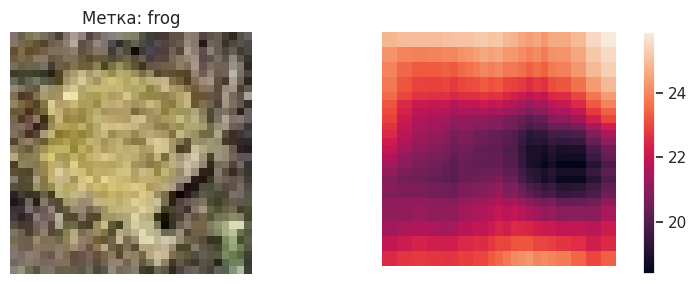

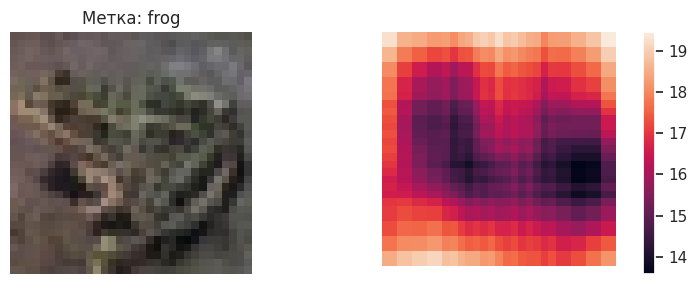

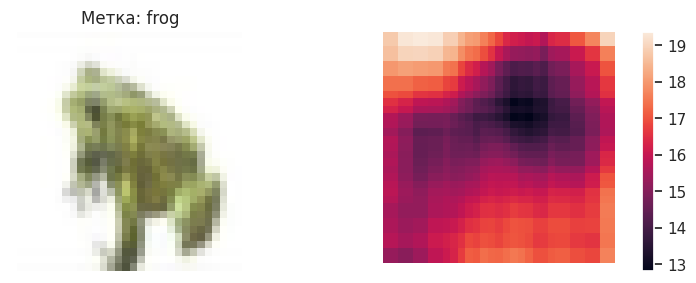

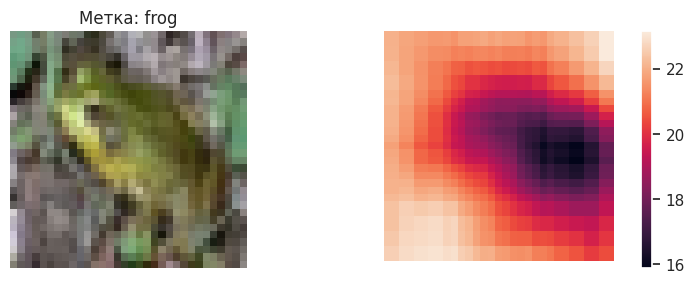

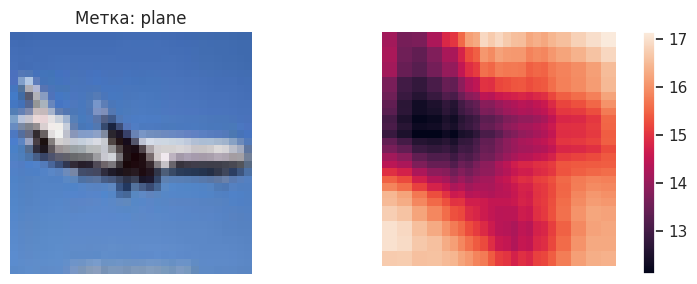

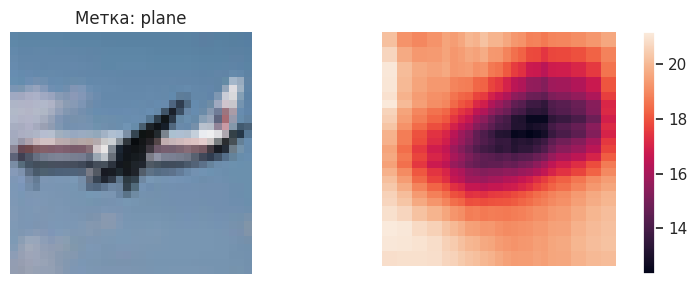

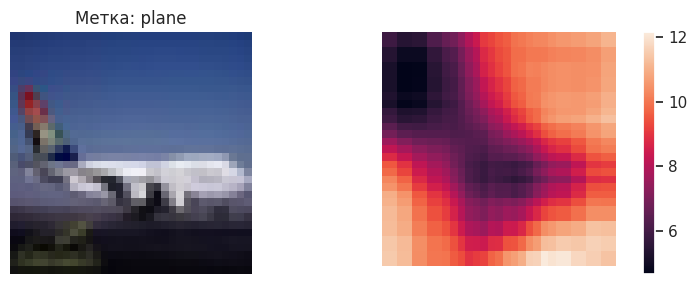

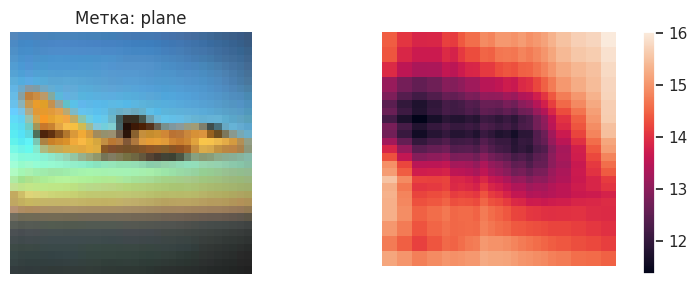

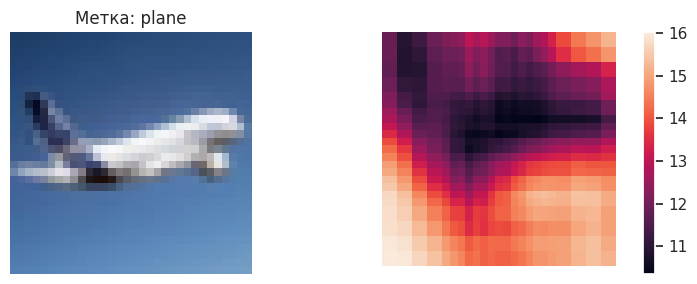

In [128]:
for frog_img in frog_images:
    show_occlusion(frog_img, best_model, classes.index('frog'), classes)

for airplane_img in plane_images:
    show_occlusion(airplane_img, best_model, classes.index('plane'), classes)

**Вывод:** 

* В случае лягушки, модель больше всего обращает внимание на то, что она имеет округлую форму.

* В случае самолета, модель пытается найти фюзеляж и крылья.

Отсюда также видим, что модель корректно обрабатывает выходы для разных классов.

На семинаре мы реализовали окклюзию самостоятельно, но она реализована и в библиотеке Captum. Выберите другие 2 класса и примените окклюзию к 5 случайным представителям из каждого класса. Пример визуализации в Captum смотрите в семинаре. Что модель считает важным для определения выбранных классов?

Будем рассматривать машины и корабли.

In [135]:
car_probs = []
ship_probs = []

# Прогоняем данные через модель и вычисляем вероятности для каждого изображения
with torch.no_grad():
    for i, (img, label) in tqdm(enumerate(val_dataset)):
        img = img.to(device)
        output = best_model(img.unsqueeze(0))
        probs = torch.softmax(output, dim=1)

        if label == classes.index("car"):
            car_probs.append((probs[0, classes.index("car")].item(), i))
        elif label == classes.index("ship"):
            ship_probs.append((probs[0, classes.index("ship")].item(), i))

# Случайным образом выбираем 5 изображений из каждого класса
car_samples = random.sample([idx for _, idx in car_probs], 5)
ship_samples = random.sample([idx for _, idx in ship_probs], 5)

# Извлекаем соответствующие изображения из датасета
car_images = [val_dataset[i][0] for i in car_samples]
ship_images = [val_dataset[i][0] for i in ship_samples]

10000it [00:09, 1028.86it/s]


In [136]:
from captum.attr import IntegratedGradients
from captum.attr import NoiseTunnel
from captum.attr import LayerGradCam

Predicted class: cat


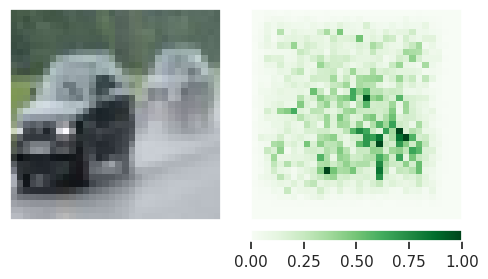

Predicted class: car


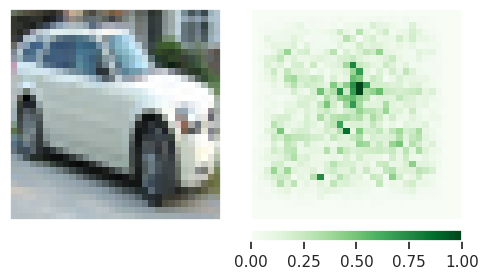

Predicted class: car


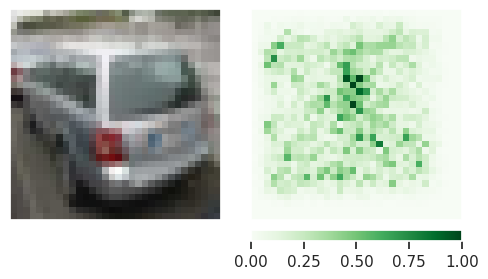

Predicted class: ship


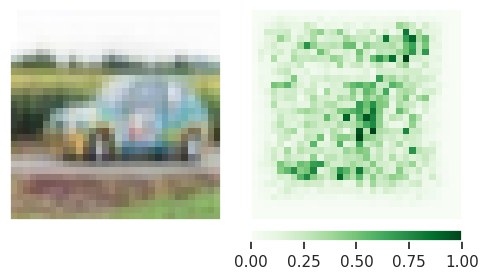

Predicted class: bird


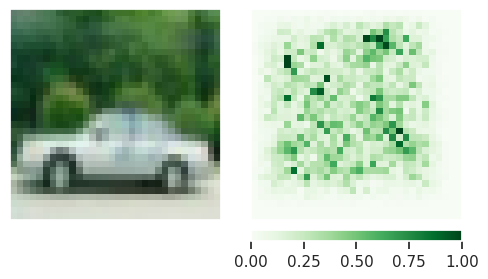

Predicted class: cat


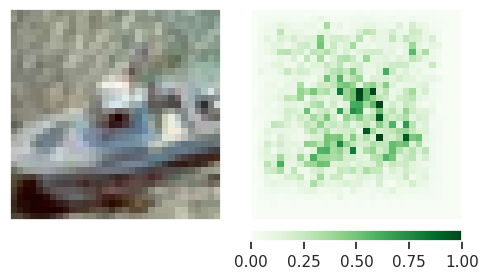

Predicted class: ship


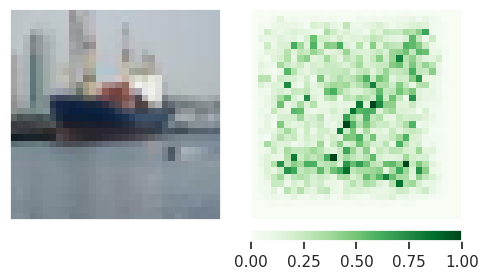

Predicted class: ship


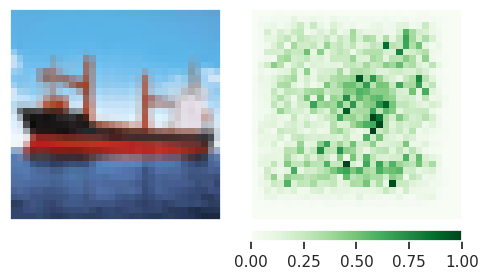

Predicted class: ship


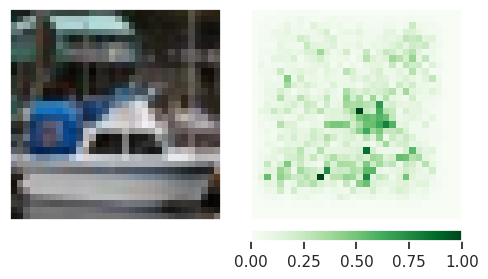

Predicted class: ship


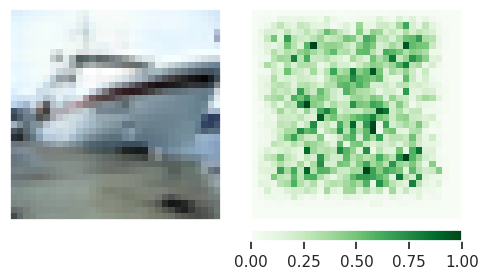

In [137]:
integrated_gradients = IntegratedGradients(best_model)
noise_tunnel = NoiseTunnel(integrated_gradients)

# Вычисление предсказаний и атрибуций для изображений автомобилей
for i, img in enumerate(car_images):
    img = img.to(device)  # Ensure image is on the correct device
    output = best_model(img.unsqueeze(0))  # Add batch dimension
    output = F.softmax(output, dim=1)  # Apply softmax to get probabilities
    prediction_score, pred_label_idx = torch.topk(output, 1)  # Get top class prediction

    print("Predicted class:", classes[pred_label_idx[0][0]])

    # Используем NoiseTunnel для вычисления атрибуций
    attributions_ig_nt = noise_tunnel.attribute(
        img.unsqueeze(0),
        nt_samples=10,
        nt_type="smoothgrad_sq",
        target=pred_label_idx[0][0],
    )

    # Визуализация
    _ = viz.visualize_image_attr_multiple(
        np.transpose(attributions_ig_nt.squeeze().detach().cpu().numpy(), (1, 2, 0)),
        np.transpose(img.squeeze().detach().cpu().numpy(), (1, 2, 0)),
        ["original_image", "heat_map"],
        ["all", "positive"],
        fig_size=(5, 3),
        show_colorbar=True,
    )

integrated_gradients = IntegratedGradients(best_model)
noise_tunnel = NoiseTunnel(integrated_gradients)

# Вычисление предсказаний и атрибуций для изображений автомобилей
for i, img in enumerate(ship_images):
    img = img.to(device)  # Ensure image is on the correct device
    output = best_model(img.unsqueeze(0))  # Add batch dimension
    output = F.softmax(output, dim=1)  # Apply softmax to get probabilities
    prediction_score, pred_label_idx = torch.topk(output, 1)  # Get top class prediction

    print("Predicted class:", classes[pred_label_idx[0][0]])

    # Используем NoiseTunnel для вычисления атрибуций
    attributions_ig_nt = noise_tunnel.attribute(
        img.unsqueeze(0),
        nt_samples=10,
        nt_type="smoothgrad_sq",
        target=pred_label_idx[0][0],
    )

    # Визуализация
    _ = viz.visualize_image_attr_multiple(
        np.transpose(attributions_ig_nt.squeeze().detach().cpu().numpy(), (1, 2, 0)),
        np.transpose(img.squeeze().detach().cpu().numpy(), (1, 2, 0)),
        ["original_image", "heat_map"],
        ["all", "positive"],
        fig_size=(5, 3),
        show_colorbar=True,
    )

В случае автомобия, модель считает самым важным его кабину.

В случае корабля, модель в первую очередь обращает внимание на воду.

#### 4. Выводы
На основе выполненного здания сделайте выводы об особенностях работы сверток.

В работе мы пронаблюдали, как различные виды сверток влияют на обучение. Например увидели, что слишком большой размер ядра свертки может быть причиной не достижения оптимального уровня точности модели. Увидили, что stride с маленьким размеров ядра значительно понижает способности модели к верным предсказаниям.

При помощи оклюзии пронаблюдали какие черты в картинках модель считает самыми важными. Например, так как в датасете нет связанных с водой объектов, кроме кораблей (безусловно есть лягушки, но вода на их фоне не имеет привычного светло синего цвета), то для того чтобы предсказать, что на фото корабль модель искала воду.